# Lab 4 Individual Analysis - Muon Lifetime

This exercise will continue with the problem of calibration curves and data transformations.  You will also expand your use of the **lmfit** package.

In [53]:
import numpy as np  # import the numpy library functions.
import scipy.constants as const # import physical constants
import matplotlib.pyplot as plt # plotting functions
import uncertainties as unc # Uncertainties package.  Good for simple error propagation
# directive below puts the plots in the notebook
%matplotlib inline

## The calibration curve



### Enter the calibration data

Analyze the calibration data of TAC peaks that come from the Digital Delay Generator.  Then enter these results along with the known time values of 1.00, 2.00, ..., 9.00 microseconds to create two arrays: `cal_channels` and `cal_times`.

In [54]:
# Channels vs. time in microseconds from TAC calibration.

cal_channels = [104, 209, 314, 420, 525, 630, 735, 840, 945]
cal_times =  [1.00, 2.00, 3.00, 4.00, 5.00, 6.00, 7.00, 8.00, 9.00]# microseconds


### Fit and extract a calibration

Use LMFIT to fit the calibration data.  Obtain parameters that will allow you to convert a channel into a time in microseconds.

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 9
    # variables        = 2
    chi-square         = 5.8789e-05
    reduced chi-square = 8.3984e-06
    Akaike info crit   = -103.449058
    Bayesian info crit = -103.054609
[[Variables]]
    slope:      0.00951021 +/- 3.5581e-06 (0.04%) (init = 0.009510214)
    intercept:  0.01030763 +/- 0.00210192 (20.39%) (init = 0.01030763)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.888

Slope =  0.009510214172012928 +/- 3.5580577947264166e-06


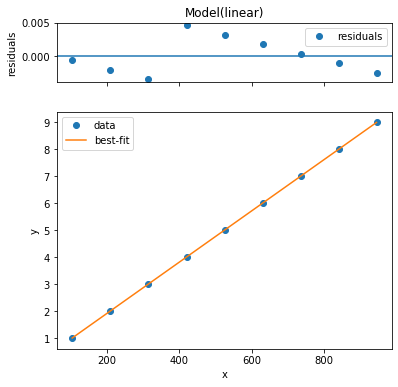

In [55]:
from lmfit.models import LinearModel

line = LinearModel()

param_guess = line.guess(cal_times, x=cal_channels)

line_fit = line.fit(cal_times, param_guess, x=cal_channels)

print(line_fit.fit_report())
print('\nSlope = ',line_fit.params['slope'].value,'+/-',line_fit.params['slope'].stderr)

line_fit.plot();

### Save the fit parameters

Save the fit parameters and their `stderr`s as `uncertainties` objects.  This will allow you to easily propagate the uncertainties in the final values.

In [56]:
# Save fit parameters as uncertainty objects
slope = unc.ufloat(line_fit.params['slope'].value, line_fit.params['slope'].stderr)
intercept = unc.ufloat(line_fit.params['intercept'].value, line_fit.params['intercept'].stderr)

def calibration(value, m=slope, b=intercept):
    result = m * value + b
    return result

## Muon lifetime data, first pass

Import the muon lifetime data from the .mca file.  Use the Python package `mcareader` to do this.  To access the mcareader package, open a terminal window and type

`pip install mcareader`

You only need to do this once.  If you get an error when you try to import `mcareader`, you do not have it installed.

The cell below shows what using mcareader looks like, using the calibration data.  Note the use of the `Mca()` function and the return structures attributes.

For an example of how to use this small Python package, see the [mcareader documentation](https://github.com/Dih5/mcareader/blob/master/demos/intro.ipynb)

/opt/conda/lib/python3.7/site-packages/mcareader.py:68: UserWarning: Warning: no calibration data was found. Using channel number instead of energy
  warnings.warn("Warning: no calibration data was found. Using channel number instead of energy")


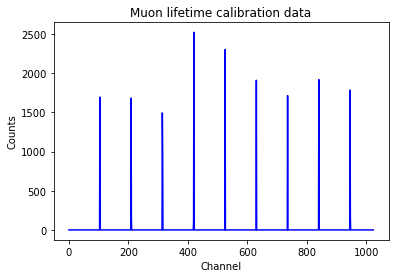

In [99]:
import mcareader as mca

TAC_cal = mca.Mca('MuLife_calibration_data.mca')

### Ignore warnings about missing calibration data.  ###

(TAC_x, TAC_y) = TAC_cal.get_points(trim_zeros=False)

plt.plot(TAC_x, TAC_y, '-b');
plt.title('Muon lifetime calibration data')
plt.ylabel('Counts')
plt.xlabel('Channel');

### Your turn: import and plot the muon lifetime data

Use what you learned in previous notebooks to plot the raw data set.  Remember to label the axes, etc.

In [58]:
# Import first
mulife_data = mca.Mca('muLife_712ks.mca')

/opt/conda/lib/python3.7/site-packages/mcareader.py:68: UserWarning: Warning: no calibration data was found. Using channel number instead of energy
  warnings.warn("Warning: no calibration data was found. Using channel number instead of energy")


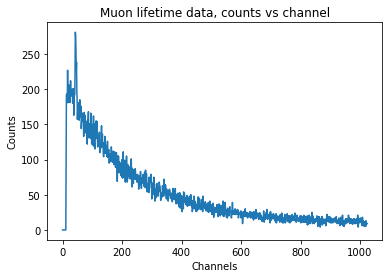

In [98]:
# Then plot

mulife_x, mulife_y = mulife_data.get_points(trim_zeros=False)

plt.plot(mulife_x, mulife_y)
plt.title('Muon lifetime data, counts vs channel')
plt.xlabel('Channels')
plt.ylabel('Counts');

### Remove the bad data

Study the data set and extract the "good" part of the data, above the spike at around channel 45.  Use a Python "slice" to do this, and replot it to make sure you have a decent set of trimmed data.

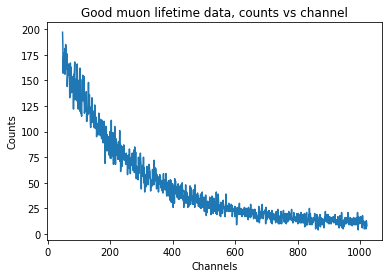

In [60]:
x = slice(48, mulife_x.size - 1)
good_mulife_x = mulife_x[x]
good_mulife_y = mulife_y[x]

plt.plot(good_mulife_x, good_mulife_y)
plt.title('Good muon lifetime data, counts vs channel')
plt.xlabel('Channels')
plt.ylabel('Counts');

## Data fitting, part 1
Fit the trimmed data to an exponential decay plus a constant background term:

$$ N(x) = Ae^{-x/\tau} + C $$

producing parameters $A$, $C$, and $\tau$ in channel units.

Do this by using the LMFIT built in models to create a "composite" model with `ExponentialModel` plus `ConstantModel`.  See LMFIT [Built-in Fitting Models](https://lmfit.github.io/lmfit-py/builtin_models.html) for an example that combines a peak model with a background model.

You will need to set the starting values of the `amplitude` ($A$), the `decay` ($\tau$) and the background constant `c` ($C$).  The `guess()` method to set the parameters will not work on composite models.  These are not hard to estimate from the data plot. Look at the plot to estimate staring values for `c`, `decay`, and `amplitude`.  Call them `start_c`, `start_ampl`, and `start_decay`. Then you can call the fit routine with

`model_fit = model.fit(trim_y, c=start_c, amplitude=start_ampl, decay=start_decay, x=trim_x)`


[[Model]]
    (Model(exponential) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 975
    # variables        = 3
    chi-square         = 42959.2980
    reduced chi-square = 44.1968086
    Akaike info crit   = 3696.93164
    Bayesian info crit = 3711.57896
[[Variables]]
    amplitude:  202.653515 +/- 1.42216581 (0.70%) (init = 200)
    decay:      219.641835 +/- 2.84788214 (1.30%) (init = 200)
    c:          9.80872293 +/- 0.47200150 (4.81%) (init = 13)
[[Correlations]] (unreported correlations are < 0.100)
    C(decay, c)         = -0.798
    C(amplitude, decay) = -0.673
    C(amplitude, c)     =  0.241


(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

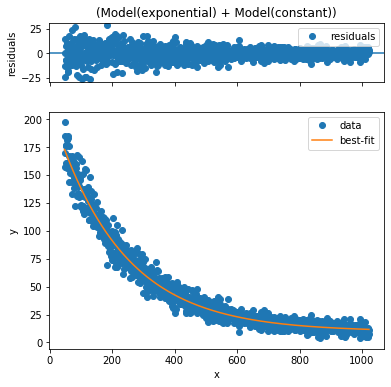

In [61]:
from lmfit.models import ExponentialModel, ConstantModel

exp_fit = ExponentialModel()
const_fit = ConstantModel()

model = exp_fit + const_fit

start_c = 13
start_ampl = 200
start_decay = 200

model_fit = model.fit(good_mulife_y, c=start_c, amplitude=start_ampl,
                  decay=start_decay, x=good_mulife_x)

print(model_fit.fit_report())
model_fit.plot()

### Replot, with a fitline

Use the `eval()` function to make a fit line, and plot it with the data.

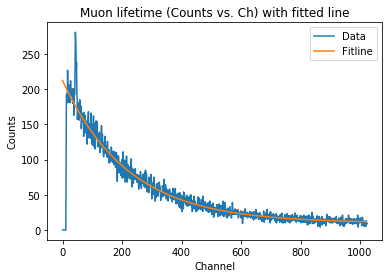

In [112]:
x_vals = np.arange(0, 1023) #set x values for all channels
y_vals = model_fit.eval(x=x_vals) #grab y values from model fit

plt.plot(mulife_x, mulife_y, label='Data') #plot all of the data
plt.plot(x_vals, y_vals, label='Fitline') #plot fitted line
plt.title('Muon lifetime (Counts vs. Ch) with fitted line')
plt.ylabel('Counts')
plt.xlabel('Channel')
plt.legend();

### Calculate the lifetime

Combine the fit results and the calibration constants along with their uncertainties to calculate a value for the lifetime and background term, including uncertainties.  Print these out with correct significant figures.  (Use the `uncertainties` package.) 

In [114]:
lt_val = model_fit.params['decay'].value
lt_err = model_fit.params['decay'].stderr

bck_val = model_fit.params['c'].value
bck_err = model_fit.params['c'].stderr

lifetime = unc.ufloat(lt_val, lt_err)
background_1 = unc.ufloat(bck_val, bck_err)

lifetime_1 = calibration(lifetime)

print('Lifetime = {:.uf}'.format(lifetime_1))
print('Background = {:.uf}'.format(background_1))

Lifetime = 2.099+/-0.027
Background = 9.8+/-0.5


## Data fitting part 1-A

Redo the fit above, but include weights for the fitting routine.  The weights should be an array, with each element being $1/\sigma_i$, where $\sigma_i$ is the uncertainty in the point.

Because this is an experiment based on random statitistics, the uncertainty in any channel is the square root of the number of counts in that channel.  This is a consequence of Poisson statistics.  So the weights array can be specified as `weights = 1.0/np.sqrt(trim_y)` where `trim_y` is the array of trimmed chanel counts.

NOTE: If you get an error about dividing by zero, either make sure you have no zeros in your data set, or add the following argument to the `fit()` function: `nan_policy='omit'`.

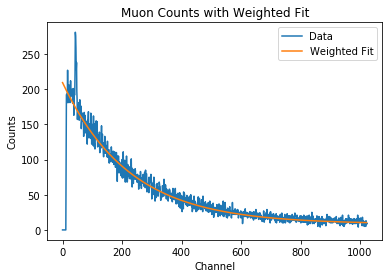

In [64]:
weights = 1.0/np.sqrt(good_mulife_y)
w_model_fit = model.fit(good_mulife_y, weights = weights, c=start_c, amplitude=start_ampl,
                  decay=start_decay, x=good_mulife_x)

w_x_vals = np.arange(0, 1023)
w_y_vals = w_model_fit.eval(x=w_x_vals)
plt.plot(mulife_x, mulife_y, label='Data')
plt.plot(w_x_vals, w_y_vals, label='Weighted Fit')
plt.title('Muon Counts with Weighted Fit')
plt.ylabel('Counts')
plt.xlabel('Channel')
plt.legend();

### Recalculate the lifetime, from the results of the weighted fit.

Redo what you did above to obtain a new version of the lifetime, based on the weighted fit.

In [105]:
lt_wval = w_model_fit.params['decay'].value
lt_werr = w_model_fit.params['decay'].stderr

bck_wval = w_model_fit.params['c'].value
bck_werr = w_model_fit.params['c'].stderr

w_lifetime = unc.ufloat(lt_wval, lt_werr)
w_background = unc.ufloat(bck_wval, bck_werr)

w_lifetime = calibration(w_lifetime)

print('Weighted Lifetime = {:.uf} microseconds'.format(w_lifetime))
print('Weighted Background = {:.uf} counts'.format(w_background))

Weighted Lifetime = 2.137+/-0.029 microseconds
Weighted Background = 10.06+/-0.32 counts


### Compare version 1 and version 1-A

Look at the `fit_report()` and comment below about the $\chi^2$ (chi-square) statistics for each version of the fit: Note the differences, and explain them.

In [66]:
print(model_fit.fit_report())
print(w_model_fit.fit_report())

[[Model]]
    (Model(exponential) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 975
    # variables        = 3
    chi-square         = 42959.2980
    reduced chi-square = 44.1968086
    Akaike info crit   = 3696.93164
    Bayesian info crit = 3711.57896
[[Variables]]
    amplitude:  202.653515 +/- 1.42216581 (0.70%) (init = 200)
    decay:      219.641835 +/- 2.84788214 (1.30%) (init = 200)
    c:          9.80872293 +/- 0.47200150 (4.81%) (init = 13)
[[Correlations]] (unreported correlations are < 0.100)
    C(decay, c)         = -0.798
    C(amplitude, decay) = -0.673
    C(amplitude, c)     =  0.241
[[Model]]
    (Model(exponential) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 975
    # variables        = 3
    chi-square         = 979.597852
    reduced chi-square = 1.00781672
    Akaike info crit   = 10.5870453
    Bayesian i

The $\chi^2$ and reduced-$\chi^2$ values for the original fit is 42959.3 and 44.2, while the values for the weighted fit is 979.6 and 1.01, respectively. Both the $\chi^2$ and reduced-$\chi^2$ values drop by a significant factor. Although comparing the $\chi^2$ values would indicate that the weighted fit has improved our fitting model, it is hard to tell whether the weighted fit is even an accurate model.
The reduced-$\chi^2$ is a much better indicator of the goodness of the fitting model. Since this has lowered to a value very close to 1.00, a better and reliable fit was obtained.

## Data fitting, part 2

Based on the record of **C-Singles**, **Valid Starts**, **Valid Conversions**, and **Elapsed Time**, your group should calculate an expected background level, per channel, for the experiment. 

Then, use that estimate in the fit as follows.  Obtain the **Parameters** structure from the previous fit, and for marameter `c` (the background constant), set its `vary` attribute to `False`, and then its `value` attribute to your expected background level.  

Feed the revised parameters into the `fit()` function, and redo the fit.  (You may leave the weight in place, or not, your choice).

Scroll to the bottom of [Getting started with Non-Linear Least-Squares Fitting](https://lmfit.github.io/lmfit-py/intro.html) to see an example of controlling the parameters.

[[Model]]
    (Model(exponential) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 975
    # variables        = 2
    chi-square         = 1011.49143
    reduced chi-square = 1.03955954
    Akaike info crit   = 39.8251181
    Bayesian info crit = 49.5899931
[[Variables]]
    amplitude:  206.303382 +/- 2.13785071 (1.04%) (init = 175)
    decay:      210.773077 +/- 1.73856002 (0.82%) (init = 200)
    c:          10.05771 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, decay) = -0.813
10.057708773539183
10289.036075330583


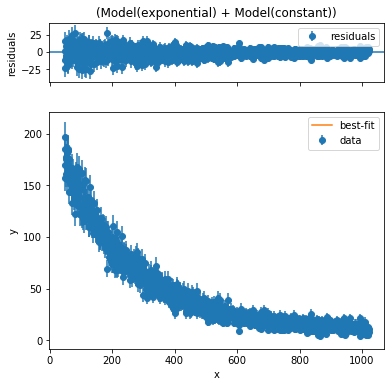

In [102]:
# Obtain the current fit parameters
c_singles = 76847900
valid_starts = 9537936
valid_conv = 55488
time = 712380

n_bkg = valid_starts * c_singles * 10e-6 / time
bkg_lvl = n_bkg / 1023
params = w_model_fit.params
params['c'].set(vary=False, value=bkg_lvl)
# You do the rest
w_model_fit_2 = model.fit(good_mulife_y, weights = weights, c=params['c'], amplitude=start_ampl,
                  decay=start_decay, x=good_mulife_x)
print(w_model_fit_2.fit_report())
w_model_fit_2.plot();

### Compare the fit curves

Create another fitline, based on the fit result with the fixed background term, and plot it over the data, along with the original fitline.

Your group will want to discuss these in the group document.

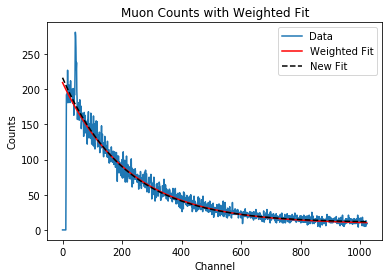

In [93]:
x_vals_2 = np.arange(0, 1023)
y_vals_2 = w_model_fit_2.eval(x=x_vals)

plt.plot(mulife_x, mulife_y, label='Data')
plt.plot(w_x_vals, w_y_vals, label='Weighted Fit', color='red')
plt.plot(x_vals_2, y_vals_2, label='New Fit', color='black', linestyle='--')
plt.title('Muon Counts with Weighted Fit')
plt.ylabel('Counts')
plt.xlabel('Channel')
plt.legend();

### Calculate the lifetime (again)

From the fit, calculate another value for the lifetime (with uncertainty).

In [104]:
lt_val_2 = w_model_fit_2.params['decay'].value
lt_err_2 = w_model_fit_2.params['decay'].stderr

lifetime_2 = unc.ufloat(lt_val_2, lt_err_2)
lifetime_2 = calibration(lifetime_2)

background_2 = unc.ufloat(w_model_fit_2.params['c'].value, w_model_fit_2.params['c'].stderr)

print('New liftime value = {:.uf}'.format(lifetime_2))

New liftime value = 2.015+/-0.017


## Data fitting, part 3

Here, you want to manipulate the data set to create a new set of data, by "coarse binning".  This means to combine the counts from adajacent channels into a single new channel.  For example, with 1024 channels, one could "rebin" by summing channels 0-15 into one bin, 16-31 in the next, 32-47 in the third, etc.  This would reduce the data set from 1024 channels to 64 channels.  By adding in this way, the scatter of the data set is reduced.  One must also adjust the `x` or channel values similarly, otherwise, the data set is scaled horizontally, and the channel-time calibration will not work.

In the following, you will write a function to rebin the data by summing over successive channels and rescaling the channel numbers.  Then you will plot and fit the results, as before, and see whether this improves anything.

### Write a function `coarse_bin()`

Define a function with the folowing specifications:

* Arguments:
  * **x** : array of *x* or channel numbers
  * **y** : array of *y* or count numbers
  * **binwidth** : the width of the new bins, or number of channels to sum together

* Returns:
  * **new_x, new_y**: A tuple of Numpy arrays of the average values of <i>x</i> and sum of values of <i>y</i>, across the number of summed channels.

In [70]:
def coarse_bin(x, y, binwidth=None):
    start_x = binwidth/2 #starting value of x
    new_x = np.arange(start_x, x.size-1, binwidth) #create array with starting point, go up in incremints
    
    new_y = []
    counter = 0 #counter for channel #
    val = 0 #tracker for sum within bin
    for i in range(y.size):
        val += y[i]
        counter += 1
        if (counter % binwidth == 0 or counter==y.size):
            val = val/binwidth #get average of channels
            new_y.append(val) #append avg to array
            val = 0 #reset sum
    return (new_x,np.array(new_y))

### Apply your function

Test your function, and see that it works correctly.  Then plot the rebinned data.

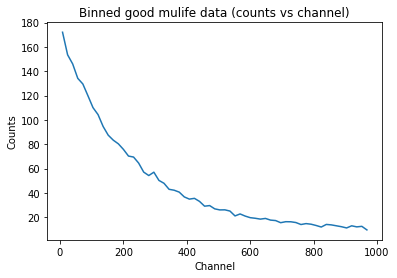

In [75]:
newx, newy = coarse_bin(good_mulife_x, good_mulife_y, binwidth=16)
plt.plot(newx, newy)
plt.title('Binned good mulife data (counts vs channel)')
plt.ylabel('Counts')
plt.xlabel('Channel');

### Fit it

Use the plot you made to estimate the starting values of the parameters for the rebinned data set.  Then fit it and extract a value for the lifetime, as you did above.

[[Model]]
    (Model(exponential) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 61
    # variables        = 3
    chi-square         = 150.941568
    reduced chi-square = 2.60244083
    Akaike info crit   = 61.2671548
    Bayesian info crit = 67.5997764
[[Variables]]
    amplitude:  163.226825 +/- 0.87750890 (0.54%) (init = 175)
    decay:      220.125778 +/- 2.77548319 (1.26%) (init = 200)
    c:          9.73241752 +/- 0.45885024 (4.71%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(decay, c)         = -0.799
    C(amplitude, decay) = -0.347


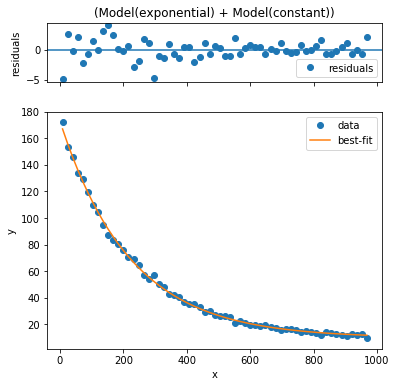

In [76]:
start_c = 10
start_ampl = 175
start_decay = 200

bin_model_fit = model.fit(newy, c=start_c, amplitude=start_ampl,
                  decay=start_decay, x=newx)

print(bin_model_fit.fit_report())
bin_model_fit.plot();

### Plot the rebinned data and the fit

If you have not done so already, plot the rebinned data and its fit curve.

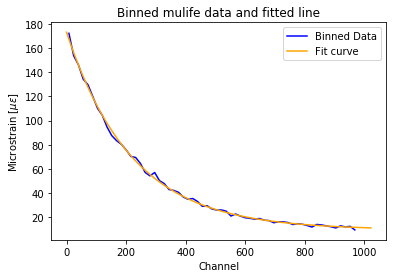

In [83]:
bin_x_vals = np.arange(0, 1023)
bin_y_vals = bin_model_fit.eval(x=bin_x_vals)

plt.plot(newx, newy, label='Binned Data', color='blue')
plt.plot(bin_x_vals, bin_y_vals, label='Fit curve', color='orange')
plt.title('Binned mulife data and fitted line')
plt.ylabel('Counts')
plt.xlabel('Channel')
plt.legend();

### Calculate lifetime and background with rebinned data

In [109]:
lifetime = unc.ufloat(bin_model_fit.params['decay'].value, bin_model_fit.params['decay'].stderr)
lifetime_bin = calibration(lifetime)

background_bin = unc.ufloat(bin_model_fit.params['c'].value, bin_model_fit.params['c'].stderr)

print('Lifetime with binned data is {:.uf} microseconds'.format(lifetime))
print('Background is {:.uf} counts'.format(background))

Lifetime with binned data is 220.1+/-2.8 microseconds
Background is 9.8+/-0.5 counts


## Muon lifetime calculation summary
Make a table with the muon lifetimes computed in steps 1, 1a, 2 and 3.
Calculated value of muon lifetime and background rate, including uncertainty.

In [115]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['Fit', 'Muon Lifetime (microseconds)', 'Background rate (counts/s)']
table.add_row(['Original Fit', lifetime_1, background_1])
table.add_row(['Weighted Fit', w_lifetime, w_background])
table.add_row(['Weighted Fit w/o Exp Bkg', lifetime_2, background_2])
table.add_row(['Binned fit', lifetime_bin, background_bin])
print(table)

+--------------------------+------------------------------+----------------------------+
|           Fit            | Muon Lifetime (microseconds) | Background rate (counts/s) |
+--------------------------+------------------------------+----------------------------+
|       Original Fit       |        2.099+/-0.027         |         9.8+/-0.5          |
|       Weighted Fit       |        2.137+/-0.029         |        10.06+/-0.32        |
| Weighted Fit w/o Exp Bkg |        2.015+/-0.017         |   10.057708773539183+/-0   |
|        Binned fit        |        2.104+/-0.026         |         9.7+/-0.5          |
+--------------------------+------------------------------+----------------------------+
